In [ ]:
import db_mysql
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm


In [3]:
start_time = '2024-09-01 00:00:00'
end_time = '2024-09-30 23:59:59'

In [4]:
# Fetch skeleton data
df = db_mysql.fetch_skeleton_data_percom(start_time, end_time)
df.head()

,BodyId,Timestamp,CameraId,AnkleLeft_X,AnkleLeft_Y,AnkleLeft_Z,AnkleRight_X,AnkleRight_Y,AnkleRight_Z,ElbowLeft_X,...,ThumbRight_Y,ThumbRight_Z,WristLeft_X,WristLeft_Y,WristLeft_Z,WristRight_X,WristRight_Y,WristRight_Z,is_valid,change_reason
0,72057594037927991,2024-09-07 08:21:12.057963,123422740247,1.419240,-0.959711,3.521488,1.400607,-0.927140,3.627700,1.555797,...,-0.195282,3.129334,1.353561,-0.044385,3.229218,1.160707,-0.148777,3.080792,1,None
1,72057594037927991,2024-09-07 08:21:12.096859,123422740247,1.427394,-0.971968,3.422590,1.455025,-0.967059,3.402945,1.527971,...,-0.154606,3.131616,1.331601,-0.019146,3.220089,1.159396,-0.143405,3.080449,1,None
2,72057594037927991,2024-09-07 08:21:12.195596,123422740247,1.421703,-0.968655,3.425286,1.452503,-0.968164,3.403705,1.410563,...,-0.191693,3.281000,1.205382,-0.064820,3.269842,1.076927,-0.119249,3.192424,1,None
3,72057594037927991,2024-09-07 08:21:12.223521,123422740247,1.421763,-0.969039,3.424586,1.447911,-0.967588,3.403106,1.413167,...,-0.194480,3.328750,1.205671,-0.061644,3.340626,1.066993,-0.114212,3.210730,1,None
4,72057594037927991,2024-09-07 08:21:12.252444,123422740247,1.413500,-0.954947,3.426383,1.444654,-0.970126,3.405888,1.384149,...,-0.155622,3.349600,1.155771,-0.038961,3.303815,1.052493,-0.103085,3.258900,1,None


In [5]:
for col in df.columns:
    if any(j in col for j in ['_X', '_Y', '_Z']):
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
angle_deg = 70.6
angle_rad = np.radians(angle_deg / 2)

z_min = 0.5     # min distance to camera (meters)
z_max = 4.5     # max distance to camera (meters)

# compute width (w) at z_max
w = 2 * z_max * np.tan(angle_rad)

In [7]:
df['SpineNegative'] = -df['SpineBase_X']

In [9]:
# 1. Total Visitor Count
# Add a Date column for daily grouping
df['Date'] = df['Timestamp'].dt.date

# Calculate total unique visitors across all days
unique_daily_visitors = df.groupby(['Date', 'BodyId']).ngroups
print("Total unique daily visitors (considering each day separately):", unique_daily_visitors)


Total unique daily visitors (considering each day separately): 702


In [10]:
total_unique_visitors = df['BodyId'].nunique()
print("Total unique visitors (counting each visitor only once across all days):", total_unique_visitors)

Total unique visitors (counting each visitor only once across all days): 672


In [11]:
df['HourOnly'] = df['Timestamp'].dt.hour
print(df['HourOnly'].value_counts().sort_index())


HourOnly
5       373
6      1160
7     17093
8     29178
9     26386
10    27850
11     4760
12    35711
13     9349
14     6750
15      271
16     1405
Name: count, dtype: int64


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert("Europe/Berlin")

In [13]:
df['HourOnly'] = df['Timestamp'].dt.hour
print(df['HourOnly'].value_counts().sort_index())

HourOnly
7       373
8      1160
9     17093
10    29178
11    26386
12    27850
13     4760
14    35711
15     9349
16     6750
17      271
18     1405
Name: count, dtype: int64


In [14]:
# Convert Timestamp to Date for grouping by day
df['Date'] = df['Timestamp'].dt.date

# Group by Date and calculate the number of unique visitors (BodyId) per day
daily_visitors = df.groupby('Date')['BodyId'].nunique()

# Display the results as a table
print("Total visitors per day:")
print(daily_visitors)


Total visitors per day:
Date
2024-09-01    93
2024-09-03     7
2024-09-04    64
2024-09-05    37
2024-09-06    22
2024-09-07    29
2024-09-08    35
2024-09-09     3
2024-09-10     1
2024-09-11    11
2024-09-12    11
2024-09-13    23
2024-09-14    46
2024-09-15    21
2024-09-17     5
2024-09-18     7
2024-09-19    42
2024-09-20     9
2024-09-21     1
2024-09-22     6
2024-09-24     8
2024-09-25    97
2024-09-26    85
2024-09-27     9
2024-09-28    10
2024-09-29    20
Name: BodyId, dtype: int64


In [15]:
df['Date'] = df['Timestamp'].dt.date

# Group by BodyId and Date, and calculate daily min and max times for each person
dwell_times = df.groupby(['BodyId', 'Date'])['Timestamp'].agg(['min', 'max'])

# Calculate daily dwell time in minutes
dwell_times['dwell_time'] = (dwell_times['max'] - dwell_times['min']).dt.total_seconds() / 60  # Convert to minutes

# Find the maximum daily dwell time and the corresponding day
max_dwell_record = dwell_times.loc[dwell_times['dwell_time'].idxmax()]
max_dwell_time = max_dwell_record['dwell_time']
max_dwell_day = max_dwell_record.name[1]  # Extracts the Date from the index

print("Maximum minutes spent in the field of view by a single person on a single day:", max_dwell_time)
print("Day on which this maximum duration occurred:", max_dwell_day)

Maximum minutes spent in the field of view by a single person on a single day: 4.640667433333333
Day on which this maximum duration occurred: 2024-09-19


In [ ]:
#Most Engaged Exhibits (e.g., using average Head position)

exhibit_positions = {
    "Flutes": {"pos": (-2, 2), "marker": "o"},  # Circle marker
    "Piano": {"pos": (0.7, 2), "marker": "d"},   # Square marker
    "Clock": {"pos": (0.7, 3), "marker": "P"}    # Pentagon marker
}

exhibit_positions = {
    "Flutes": (-2, 2),
    "Piano": (0.7, 2),
    "Clock": (0.7, 3)
}

# Function to calculate the closest exhibit based on SpineBase_X, SpineBase_Z positions
def closest_exhibit(x, z):
    # Convert x and z to floats for compatibility
    x, z = float(x), float(z)
    distances = {exhibit: np.sqrt((x - float(pos[0])) ** 2 + (z - float(pos[1])) ** 2) for exhibit, pos in exhibit_positions.items()}
    return min(distances, key=distances.get)  # Returns the exhibit with the minimum distance

# Apply the function to each row to determine the nearest exhibit
df['nearest_exhibit'] = df.apply(lambda row: closest_exhibit(row['SpineNegative'], row['SpineBase_Z']), axis=1)


In [17]:
# Count the number of unique (BodyId, Date) pairs per exhibit
engagement = df.groupby(['nearest_exhibit', 'Date'])['BodyId'].nunique().groupby('nearest_exhibit').sum()
print("Visitor engagement per exhibit:")
print(engagement)

Visitor engagement per exhibit:
nearest_exhibit
Clock     397
Flutes    552
Piano     330
Name: BodyId, dtype: int64


In [18]:
exhibit_positions = {
    "Flutes": {"pos": (-2, 2), "marker": "o"},  # Circle marker
    "Piano": {"pos": (0.7, 2), "marker": "d"},   # Square marker
    "Clock": {"pos": (0.7, 3), "marker": "P"}    # Pentagon marker
}

In [24]:
df['HourOnly'] = df['Timestamp'].dt.hour
print(df['HourOnly'].value_counts().sort_index())


HourOnly
7       373
8      1160
9     17093
10    29178
11    26386
12    27850
13     4760
14    35711
15     9349
16     6750
17      271
18     1405
Name: count, dtype: int64


In [25]:
exhibit_positions = {
    "Flutes": {"pos": (-2, 2), "marker": "o"},  # Circle marker
    "Piano": {"pos": (0.7, 2), "marker": "d"},   # Square marker
    "Clock": {"pos": (0.7, 3), "marker": "P"}    # Pentagon marker
}


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


proximity_threshold = 1.0 # meters
min_dwell_time = pd.Timedelta(seconds=5)

# Sort for proper time diff calculation
df_analysis = df.sort_values(by=['BodyId', 'Timestamp'])

# Assign closest exhibit if within threshold
def assign_exhibit(row):
    x = float(row['SpineNegative'])
    z = float(row['SpineBase_Z'])
    for name, data in exhibit_positions.items():
        dx = x - data['pos'][0]
        dz = z - data['pos'][1]
        dist = np.sqrt(dx**2 + dz**2)
        if dist <= proximity_threshold:
            return name
    return None


df_analysis['Exhibit'] = df_analysis.apply(assign_exhibit, axis=1)
#df_analysis = df_analysis.dropna(subset=['Exhibit'])  # Keep only those near an exhibit

# Compute dwell durations per person per exhibit (consecutive stay)
df_analysis['TimeDiff'] = df_analysis.groupby(['BodyId', 'Exhibit'])['Timestamp'].diff()
df_analysis['Block'] = (df_analysis['TimeDiff'] > pd.Timedelta(seconds=10)).cumsum()  # new visit block

# Aggregate visits
dwell_blocks = (
    df_analysis.groupby(['BodyId', 'Exhibit', 'Block'])
    .agg(VisitStart=('Timestamp', 'min'), VisitEnd=('Timestamp', 'max'))
    .reset_index()
)
dwell_blocks['DwellTime'] = dwell_blocks['VisitEnd'] - dwell_blocks['VisitStart']
dwell_blocks = dwell_blocks[dwell_blocks['DwellTime'] >= min_dwell_time]

# Final dwell stats per exhibit
dwell_df = dwell_blocks.groupby('Exhibit')['DwellTime'].agg(
    Count='count',
    Min='min',
    Max='max',
    Avg='mean'
).reset_index()


In [27]:
dwell_df['Min'] = dwell_df['Min'].dt.total_seconds()
dwell_df['Max'] = dwell_df['Max'].dt.total_seconds()
dwell_df['Avg'] = dwell_df['Avg'].dt.total_seconds()

In [28]:
dwell_df

,Exhibit,Count,Min,Max,Avg
0,Clock,20,5.092849,101.620121,19.220716
1,Flutes,58,5.331197,68.567185,15.150678
2,Piano,55,5.046512,26.359994,10.201436


In [29]:
# Calculate distances per frame to each exhibit for assigned ones
def compute_distance(row):
    ex_pos = exhibit_positions[row['Exhibit']]['pos']
    x, z = float(row['SpineNegative']), float(row['SpineBase_Z'])
    dx = x - ex_pos[0]
    dz = z - ex_pos[1]
    return np.sqrt(dx**2 + dz**2)

# Filter to valid exhibit assignments
df_valid = df_analysis.dropna(subset=['Exhibit']).copy()

df_valid['DistanceToExhibit'] = df_valid.apply(compute_distance, axis=1)

# Aggregate min, max, avg distance per exhibit
distance_stats = df_valid.groupby('Exhibit')['DistanceToExhibit'].agg(
    Min='min',
    Max='max',
    Avg='mean'
).reset_index()

print(distance_stats)

  Exhibit       Min       Max       Avg
0   Clock  0.338189  0.999990  0.820985
1  Flutes  0.484360  0.999998  0.821760
2   Piano  0.135626  0.999996  0.726443


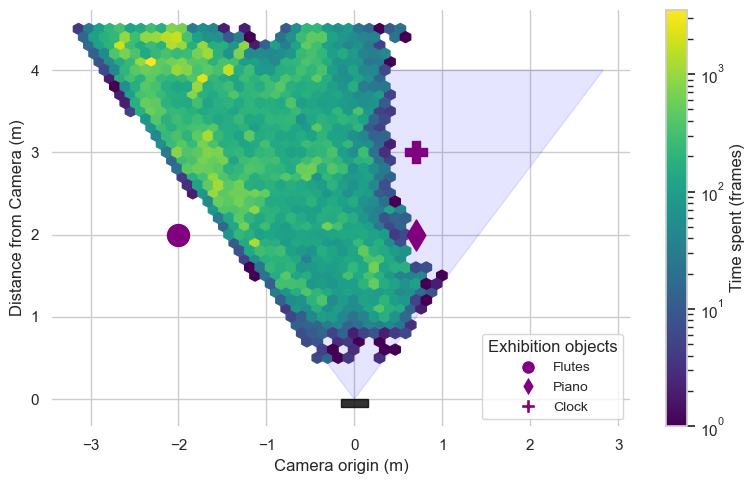

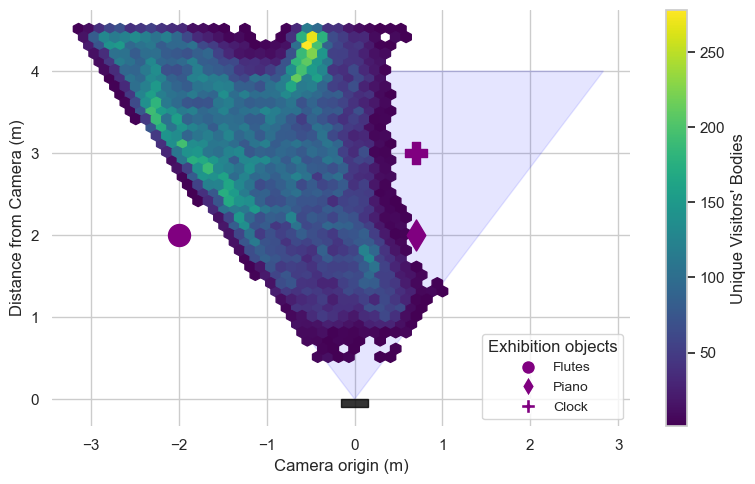

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

# --- Camera FOV drawing function ---
def draw_camera_fov(ax):
    angle_radians = np.radians(70.6)  # Kinect v2 FOV
    fov_depth = 4
    half_base = fov_depth * np.tan(angle_radians / 2)
    ax.fill([0, half_base, -half_base],
            [0, fov_depth, fov_depth],
            color='blue', alpha=0.1, label='Camera FOV')

# --- Rectangles (optional objects like barriers or stands) ---
rectangles = [
    {"xy": (-0.15, -0.1), "width": 0.3, "height": 0.1,
     "color": "black", "alpha": 0.8}
]

# --- Exhibition objects ---
exhibit_positions = {
    "Flutes": {"pos": (-2, 2), "marker": "o"},  # Circle marker
    "Piano": {"pos": (0.7, 2), "marker": "d"},   # Square marker
    "Clock": {"pos": (0.7, 3), "marker": "P"}    # Pentagon marker
}
# --- Data prep ---
df['SpineNegative'] = -pd.to_numeric(df['SpineBase_X'], errors='coerce')
df['SpineBase_Z']   = pd.to_numeric(df['SpineBase_Z'], errors='coerce')
x_data = df['SpineNegative']
y_data = df['SpineBase_Z']

grid_size = 35
df['x_bin'] = (df['SpineNegative'] * grid_size).round().astype(int)
df['y_bin'] = (df['SpineBase_Z'] * grid_size).round().astype(int)
unique_counts = (
    df.groupby(['x_bin', 'y_bin'])['BodyId']
      .nunique()
      .reset_index(name='UniqueBodies')
)
x_unique = unique_counts['x_bin'] / grid_size
y_unique = unique_counts['y_bin'] / grid_size
counts_unique = unique_counts['UniqueBodies']

# --- Plot A: Time density ---
def plot_time_density():
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5))
    draw_camera_fov(ax)

    hb = ax.hexbin(
        x_data, y_data,
        gridsize=grid_size,
        cmap="viridis",
        norm=LogNorm(vmin=1)
    )
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Time spent (frames)")

    for rect in rectangles:
        ax.add_patch(patches.Rectangle(rect['xy'], rect['width'], rect['height'],
                                       color=rect['color'], alpha=rect['alpha']))
    for exhibit, data in exhibit_positions.items():
        ax.scatter(*data["pos"], color='purple', marker=data["marker"], s=250)

    legend_handles = [
        Line2D([0], [0], marker="o", color='w', markerfacecolor='purple', markersize=10, label="Flutes"),
        Line2D([0], [0], marker="d", color='w', markerfacecolor='purple', markersize=10, label="Piano"),
        Line2D([0], [0], marker="P", color='w', markerfacecolor='purple', markersize=10, label="Clock"),
    ]
    ax.legend(handles=legend_handles, title="Exhibition objects",
              fontsize=10, title_fontsize=12, loc="lower right", frameon=True)


    ax.set_xlabel("Camera origin (m)", fontsize=12)
    ax.set_ylabel("Distance from Camera (m)", fontsize=12)
    sns.despine(ax=ax, left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# --- Plot B: Unique visitors ---
def plot_unique_visitors():
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8,5))
    draw_camera_fov(ax)

    hb = ax.hexbin(
        x_unique, y_unique,
        C=counts_unique,
        reduce_C_function=np.sum,
        gridsize=grid_size,
        cmap="viridis"
    )
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Unique Visitors' Bodies")

    for rect in rectangles:
        ax.add_patch(patches.Rectangle(rect['xy'], rect['width'], rect['height'],
                                       color=rect['color'], alpha=rect['alpha']))
    for exhibit, data in exhibit_positions.items():
        ax.scatter(*data["pos"], color='purple', marker=data["marker"], s=250)

    legend_handles = [
        Line2D([0], [0], marker="o", color='w', markerfacecolor='purple', markersize=10, label="Flutes"),
        Line2D([0], [0], marker="d", color='w', markerfacecolor='purple', markersize=10, label="Piano"),
        Line2D([0], [0], marker="P", color='w', markerfacecolor='purple', markersize=10, label="Clock"),
    ]
    ax.legend(handles=legend_handles, title="Exhibition objects",
              fontsize=10, title_fontsize=12, loc="lower right", frameon=True)

    ax.set_xlabel("Camera origin (m)", fontsize=12)
    ax.set_ylabel("Distance from Camera (m)", fontsize=12)
    sns.despine(ax=ax, left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# --- Call functions ---
plot_time_density()
plot_unique_visitors()


In [31]:
plt.savefig("time_density.png", dpi=300, bbox_inches="tight")
plt.savefig("unique_visitors.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

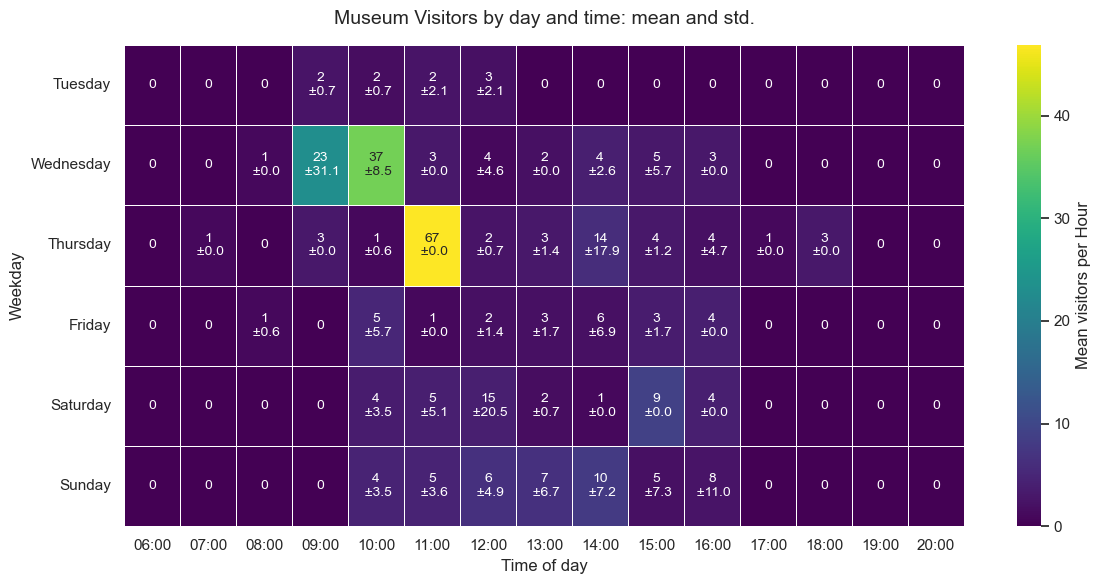

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Prepare timestamps and categorical labels ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Week'] = df['Timestamp'].dt.isocalendar().week
df['Weekday'] = df['Timestamp'].dt.day_name()
df['Hour'] = df['Timestamp'].dt.floor('1h').dt.strftime('%H:%M')

# Exclude Monday (museum closed)
weekday_order = ["Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df = df[df['Weekday'].isin(weekday_order)]
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)

# --- 2️⃣ Count unique visitors per week/weekday/hour ---
weekly_counts = (
    df.groupby(['Week', 'Weekday', 'Hour'], observed=True)['BodyId']
      .nunique()
      .reset_index()
      .rename(columns={'BodyId': 'Visitors'})
)

# --- 3️⃣ Aggregate across weeks ---
stats = (
    weekly_counts.groupby(['Weekday', 'Hour'], observed=True)['Visitors']
        .agg(['mean', 'std', 'sum','median'])
        .reset_index()
)

# --- 4️⃣ Pivot for plotting ---
expected_hours = pd.date_range("06:00", "20:00", freq="1h").strftime("%H:%M")
heat_mean = stats.pivot(index='Weekday', columns='Hour', values='mean').reindex(columns=expected_hours).fillna(0)
heat_std  = stats.pivot(index='Weekday', columns='Hour', values='std').reindex(columns=expected_hours).fillna(0)
heat_sum  = stats.pivot(index='Weekday', columns='Hour', values='sum').reindex(columns=expected_hours).fillna(0)
heat_median  = stats.pivot(index='Weekday', columns='Hour', values='median').reindex(columns=expected_hours).fillna(0)

# --- 5️⃣ Annotate (Mean ± σ) ---
annot = heat_mean.copy().astype(str)
for i in heat_mean.index:
    for j in heat_mean.columns:
        m, s, c, med = heat_mean.loc[i, j], heat_std.loc[i, j], heat_sum.loc[i,j], heat_median.loc[i,j]
        if m == 0 and s == 0:
            annot.loc[i, j] = f"{m:.0f}"
        else:
            annot.loc[i, j] = f"{m:.0f}\n ±{s:.1f}"
            #Total:{c:.0f}#

# --- 6️⃣ Plot ---
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heat_median,
    cmap="viridis",
    annot=annot,
    fmt='',
    linewidths=0.4,
    linecolor="white",
    cbar_kws={'label': 'Mean visitors per Hour'},
    vmin=0,
    vmax=heat_median.values.max() * 0.7
)

# Format annotation styles
for t in ax.texts:
    if '±' in t.get_text():        
        #t.set_fontweight('bold')
        t.set_fontsize(10)
    else:
        t.set_fontsize(10)

plt.title("Museum Visitors by day and time: mean and std.", fontsize=14, pad=15)
plt.xlabel("Time of day", fontsize=12)
plt.ylabel("Weekday", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
